# Recommender Systems

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import chardet
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

## Loading data

It appears that there is inconsistency in the text encoding used in various data files. As a result, we must verify the encoding to ensure accurate data reading from these files.

In [23]:
def get_file_encoding(file_path):
    """
    This function checks the text enconding used in a particular file
    
    :param file_path: The file path you wish to examine for its encoding
    :return: String containing enconding type
    """
    
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        return result['encoding']

In [24]:
# Loading ratings data
ratings_path = "./ml-1m/ml-1m/ratings.dat"
ratings = pd.read_csv(ratings_path, delimiter="::", header=None, engine='python', encoding=get_file_encoding(ratings_path))
ratings = ratings.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3:"Timestamp"}) # Set ratings column names

ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [25]:
#Loading movies data
movies_path = "./ml-1m/ml-1m/movies.dat"
movies = pd.read_csv(movies_path, delimiter="::", header=None, engine='python', encoding= get_file_encoding(movies_path))
movies = movies.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})

movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [26]:
#Loading users data
users_path = "./ml-1m/ml-1m/users.dat"
users = pd.read_csv(users_path, delimiter="::", header=None, engine='python', encoding= get_file_encoding(users_path))
users = users.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Pre-processing Data

In [27]:
le = LabelEncoder()

In [28]:
unique_users_ids = ratings['UserID'].unique()
# Assuming your movies features matrix is named 'movies_features_df'
filtered_users = users[users['UserID'].isin(unique_users_ids)]

unique_movies_ids = ratings['MovieID'].unique()
# Assuming your movies features matrix is named 'movies_features_df'
filtered_movies = movies[movies['MovieID'].isin(unique_movies_ids)]


filtered_movies.loc[:, 'MovieID'] = le.fit_transform(filtered_movies['MovieID'])
filtered_users.loc[:, 'UserID'] = le.fit_transform(filtered_users['UserID'])

In [29]:
user_movie_ratings = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

In [30]:
# Encode columns (MovieIDs)
user_movie_ratings.columns = le.fit_transform(user_movie_ratings.columns)

# Encode row names (UserIDs)
user_movie_ratings.index = le.fit_transform(user_movie_ratings.index)

# Matrix Factorization

In [31]:
class MatrixFactorization:
    def __init__(self, K=10, max_iter=75, eta=0.005, lamda=0.05):
        self.K = K  # Number of latent features
        self.max_iter = max_iter  # Maximum number of iterations
        self.eta = eta  # Learning rate
        self.lamda = lamda  # Regularization parameter

    def fit(self, train_set):
        self.zero_rows=np.where(~train_set.values.any(axis=1))[0]
        self.zero_columns=np.where(~train_set.values.any(axis=0))[0]
        prev_rmse = float('inf')
        consecutive_increase_count = 0
        probe_subset = [(i, j, train_set.iloc[i, j]) for i in range(len(train_set)) for j in range(len(train_set.columns)) if train_set.iloc[i, j] > 0]
        N, Z = train_set.shape  # Dimensions of the user-item matrix
        self.train_set_values=train_set.values
        self.U = np.random.rand(N, self.K)  # Initialize user matrix randomly
        self.M = np.random.rand(Z, self.K)  # Initialize movie matrix randomly
        for step in range(self.max_iter):
            # Calculate errors for non-zero entries in train_set
            errors = (train_set.values > 0) * (train_set.values - np.dot(self.U, self.M.T))

            # Calculate gradients for U and M using matrix operations
            gradient_U = 2 * (np.dot(errors, self.M) - self.lamda * self.U)
            gradient_M = 2 * (np.dot(errors.T, self.U) - self.lamda * self.M)

            # Update U and M using matrix operations
            self.U += self.eta * gradient_U
            self.M += self.eta * gradient_M

            # Calculate RMSE on the probe subset
            probe_rmse = self.get_rmse(probe_subset)
            probe_mae = self.get_mae(probe_subset)
            print("Iteration:", step + 1, " RMSE:", probe_rmse, " MAE:", probe_mae)

            # Check for convergence by comparing RMSE with the previous iteration
            if probe_rmse >= prev_rmse:
                consecutive_increase_count += 1
                if consecutive_increase_count >= 2 and probe_rmse<=1:
                    print("Converged. RMSE did not decrease for 2 consecutive iterations.")
                    print('Train RMSE:',probe_rmse)
                    print('Train MAE:',probe_mae)
                    break
            else:
                consecutive_increase_count = 0

            prev_rmse = probe_rmse
        

        return probe_rmse,probe_mae

    def predict(self):
        return np.dot(self.U, self.M.T)
    

    def test_rmse_mae(self, test_data):
        test_data = test_data.values  
        nR = np.dot(self.U, self.M.T)


        # Create a mask for non-zero entries in the test data
        non_zero_mask = (test_data > 0) & np.logical_not(np.isin(np.arange(len(test_data)), self.zero_rows)[:, np.newaxis]) & np.logical_not(np.isin(np.arange(len(test_data[0])), self.zero_columns))
        actual_ratings = test_data[non_zero_mask]
        predicted_ratings = nR[non_zero_mask]

        rmse = np.sqrt(np.mean((predicted_ratings - actual_ratings) ** 2))
        mae = np.mean(np.abs(predicted_ratings - actual_ratings))

        return rmse, mae


    def get_rmse(self, probe_subset):
        rmse = 0
        count = 0
        for i, j, actual_rating in probe_subset:
            predicted_rating = np.dot(self.U[i, :], self.M[j, :])
            rmse += (predicted_rating - actual_rating) ** 2
            count += 1
        rmse = np.sqrt(rmse / count)
        return rmse

    def get_mae(self, probe_subset):
        mae = 0
        count = 0
        for i, j, actual_rating in probe_subset:
            predicted_rating = np.dot(self.U[i, :], self.M[j, :])
            mae += np.abs(predicted_rating - actual_rating)
            count += 1
        mae = mae / count
        return mae
    



## Cross validation

In [32]:
def cross_validation(model, data_df, num_folds=5):

    
    num_users, num_movies = data_df.shape

    # Create a list of (user, movie, rating) tuples from the DataFrame
    data = [(user, movie, data_df.iloc[user, movie]) for user in range(num_users) for movie in range(num_movies) if data_df.iloc[user, movie] != 0]

 
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize empty DataFrames for train and test sets
    train_sets = [pd.DataFrame(np.zeros((num_users, num_movies))) for _ in range(num_folds)]
    test_sets = [pd.DataFrame(np.zeros((num_users, num_movies))) for _ in range(num_folds)]

    # Iterate through the folds
    train_sum_rmse = 0
    train_sum_mae = 0

    test_sum_rmse = 0
    test_sum_mae = 0

    for fold, (train_index, test_index) in enumerate(kf.split(data), 1):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]
        
        # Fill train and test DataFrames with ratings from the respective data tuples
        for user, movie, rating in train_data:
            train_sets[fold - 1].iloc[user, movie] = rating
        
        for user, movie, rating in test_data:
            test_sets[fold - 1].iloc[user, movie] = rating
        
        mf = model
        (train_rmse,train_mae) = mf.fit(train_sets[fold - 1])
        
        
        (test_rmse,test_mae) =mf.test_rmse_mae(test_sets[fold - 1])

        print('Train RMSE for fold:',fold,':', train_rmse)
        print('Train MAE for fold:',fold,':', train_mae)

        print('Test RMSE for fold:',fold,':', test_rmse)
        print('Test MAE for fold:',fold,':', test_mae)

        train_sum_rmse = train_sum_rmse + train_rmse
        train_sum_mae = train_sum_mae + train_mae


        test_sum_rmse = test_sum_rmse + test_rmse
        test_sum_mae = test_sum_mae + test_mae

    overall_train_rmse=train_sum_rmse/num_folds
    overall_train_mae=train_sum_mae/num_folds

    overall_test_rmse=test_sum_rmse/num_folds
    overall_test_mae=test_sum_mae/num_folds

    print('Overall Train RMSE:',overall_train_rmse)
    print('Overall Train MAE:',overall_train_mae)

    print('Overall Test RMSE:',overall_test_rmse)
    print('Overall Test MAE:',overall_test_mae)



    

## Implement

In [33]:
#test on small subset #delete this sell after
movies=movies.loc[:30,:]
users=users.loc[:60,:]
user_movie_ratings=user_movie_ratings.loc[:60,:30]

In [34]:
model=MatrixFactorization()
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 1.4214673675450855  MAE: 1.163748894083428
Iteration: 2  RMSE: 1.1726405034002931  MAE: 0.9277457896469309
Iteration: 3  RMSE: 1.0204595909200045  MAE: 0.7831775947301048
Iteration: 4  RMSE: 0.920831699782218  MAE: 0.7050838345562741
Iteration: 5  RMSE: 0.8492289304096541  MAE: 0.6517629657435964
Iteration: 6  RMSE: 0.7938330200608352  MAE: 0.6079127665623293
Iteration: 7  RMSE: 0.748792110562526  MAE: 0.5731480749706878
Iteration: 8  RMSE: 0.710909637233525  MAE: 0.5432420549501842
Iteration: 9  RMSE: 0.678257476873476  MAE: 0.5174384351194918
Iteration: 10  RMSE: 0.6495826297668515  MAE: 0.49528440707710925
Iteration: 11  RMSE: 0.6240268796171818  MAE: 0.4758443922258171
Iteration: 12  RMSE: 0.600978697169718  MAE: 0.4577389893074224
Iteration: 13  RMSE: 0.5799878898379814  MAE: 0.4413540783011564
Iteration: 14  RMSE: 0.5607135145832662  MAE: 0.42633966254238265
Iteration: 15  RMSE: 0.5428908875222347  MAE: 0.4121498583382662
Iteration: 16  RMSE: 0.526310110665671

In [35]:
model=MatrixFactorization(K=10)
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 1.3709173039418976  MAE: 1.1675542677040844
Iteration: 2  RMSE: 1.114674882510311  MAE: 0.9232051368971548
Iteration: 3  RMSE: 0.9692386602698708  MAE: 0.7809376622717193
Iteration: 4  RMSE: 0.8791551564784468  MAE: 0.6979442399851264
Iteration: 5  RMSE: 0.8163594210979995  MAE: 0.6418509768924355
Iteration: 6  RMSE: 0.768616364502348  MAE: 0.6004030820864962
Iteration: 7  RMSE: 0.7302241733194336  MAE: 0.5689600145356566
Iteration: 8  RMSE: 0.6981925995348591  MAE: 0.5433123075146826
Iteration: 9  RMSE: 0.6707802214973742  MAE: 0.5219035437530143
Iteration: 10  RMSE: 0.6468832439629605  MAE: 0.5021645693026745
Iteration: 11  RMSE: 0.625753294571966  MAE: 0.4843660337769094
Iteration: 12  RMSE: 0.6068554398030322  MAE: 0.46808769457780286
Iteration: 13  RMSE: 0.5897911940896869  MAE: 0.45303800044584674
Iteration: 14  RMSE: 0.5742539860256376  MAE: 0.4390356442311944
Iteration: 15  RMSE: 0.5600019570616702  MAE: 0.42595883136492585
Iteration: 16  RMSE: 0.54684055744

In [36]:
model=MatrixFactorization(K=15)
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 1.04600261394452  MAE: 0.8214910662410339
Iteration: 2  RMSE: 0.9521842600340839  MAE: 0.7519941478604705
Iteration: 3  RMSE: 0.883186718381247  MAE: 0.6983082890186569
Iteration: 4  RMSE: 0.8285551208534437  MAE: 0.6571402232624654
Iteration: 5  RMSE: 0.7834362913811916  MAE: 0.6219013378934339
Iteration: 6  RMSE: 0.7449994239442823  MAE: 0.5927522303860961
Iteration: 7  RMSE: 0.7114644650639049  MAE: 0.5664889720892761
Iteration: 8  RMSE: 0.6816602730675329  MAE: 0.5429380577691648
Iteration: 9  RMSE: 0.654786950088016  MAE: 0.5211242176238338
Iteration: 10  RMSE: 0.630279645433175  MAE: 0.5007308103205419
Iteration: 11  RMSE: 0.6077272638702517  MAE: 0.4816057363646105
Iteration: 12  RMSE: 0.5868222868901686  MAE: 0.4636181328902844
Iteration: 13  RMSE: 0.5673288670325176  MAE: 0.44665516934547717
Iteration: 14  RMSE: 0.5490619922551151  MAE: 0.4309049227829371
Iteration: 15  RMSE: 0.5318735450302232  MAE: 0.41655734826815016
Iteration: 16  RMSE: 0.51564276450199

In [37]:
model=MatrixFactorization(K=20)
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 1.2586765344480288  MAE: 0.9718361793252458
Iteration: 2  RMSE: 1.0517252995968214  MAE: 0.8277916250937483
Iteration: 3  RMSE: 0.942401358904046  MAE: 0.7467518093432735
Iteration: 4  RMSE: 0.8680574218655509  MAE: 0.6906063010606897
Iteration: 5  RMSE: 0.8103068942656899  MAE: 0.6452985251461204
Iteration: 6  RMSE: 0.7620335169173729  MAE: 0.6065057941998843
Iteration: 7  RMSE: 0.7199320532370327  MAE: 0.5728718521903596
Iteration: 8  RMSE: 0.6822483184576398  MAE: 0.5425802929512392
Iteration: 9  RMSE: 0.6479516703259954  MAE: 0.5151053866157231
Iteration: 10  RMSE: 0.6163861796538026  MAE: 0.4894229693417686
Iteration: 11  RMSE: 0.5871064612937235  MAE: 0.4652977825902195
Iteration: 12  RMSE: 0.559793390358668  MAE: 0.44293520370261497
Iteration: 13  RMSE: 0.5342077450696409  MAE: 0.4218872709985884
Iteration: 14  RMSE: 0.5101632577684629  MAE: 0.4020844261456045
Iteration: 15  RMSE: 0.487510213154687  MAE: 0.3836510625996293
Iteration: 16  RMSE: 0.4661250640939

# Visualization

## Data preparation

In [ ]:
#function to categorize years into decades
def categorize_decade(year):
    return f'{year // 10 * 10}s'

In [38]:
movies_df=filtered_movies
movies_df.loc[:, 'Year'] = movies_df['Title'].str.extract(r'\((\d{4})\)')[0]
movies_df=movies_df[['MovieID', 'Genres', 'Year']]
movies_df.loc[:,'Year'] = movies_df['Year'].astype(int)
movies_df.loc[:,'Year'] = movies_df['Year'].astype(int)
movies_df['Decade'] = movies_df['Year'].apply(categorize_decade)


users_df=filtered_users[["UserID", "Gender", "Age"]]

In [39]:
model_v=MatrixFactorization()
data_df_v=user_movie_ratings
model_v.fit(data_df_v)
U = model_v.U
M = model_v.M

Iteration: 1  RMSE: 1.2253188147858207  MAE: 0.9815311222564742
Iteration: 2  RMSE: 1.027675742683499  MAE: 0.7940487333973894
Iteration: 3  RMSE: 0.9128041748476979  MAE: 0.6909558043235267
Iteration: 4  RMSE: 0.8399563440158343  MAE: 0.6216284380424115
Iteration: 5  RMSE: 0.7899897145077026  MAE: 0.58215720043063
Iteration: 6  RMSE: 0.7531030512933761  MAE: 0.5570364137426351
Iteration: 7  RMSE: 0.7240829035270561  MAE: 0.5383551456007416
Iteration: 8  RMSE: 0.7000678824974504  MAE: 0.5239496589306847
Iteration: 9  RMSE: 0.6794244615301914  MAE: 0.5118331815903361
Iteration: 10  RMSE: 0.6611774126031434  MAE: 0.5003005759982613
Iteration: 11  RMSE: 0.6447158727049058  MAE: 0.4895367797339472
Iteration: 12  RMSE: 0.6296377034437437  MAE: 0.47928617215459224
Iteration: 13  RMSE: 0.6156648722617485  MAE: 0.4693894970230931
Iteration: 14  RMSE: 0.6025962066036454  MAE: 0.45992148409825917
Iteration: 15  RMSE: 0.5902802535173831  MAE: 0.4507376111360339
Iteration: 16  RMSE: 0.578599186236

# PCA

## Users

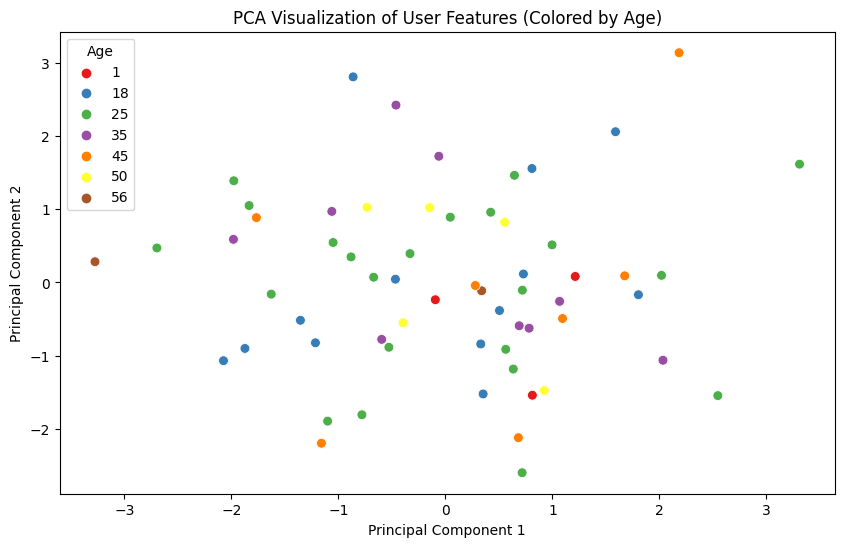

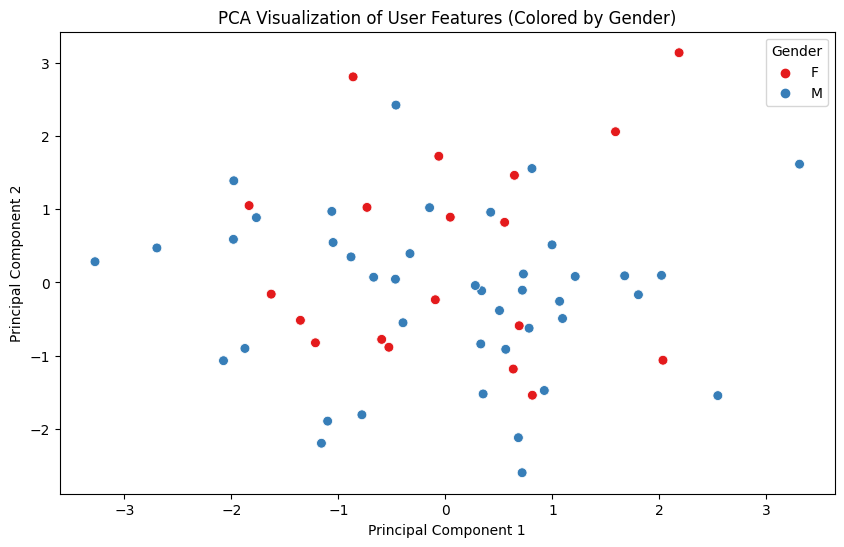

In [40]:
# Apply PCA with 2 components for visualization
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(U)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate PCA results with user information
final_df = pd.concat([pca_df, users_df[['Gender', 'Age']]], axis=1)

# Visualize using seaborn
# age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Age', data=final_df, palette='Set1', s=50)
plt.title('PCA Visualization of User Features (Colored by Age)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Gender', data=final_df, palette='Set1', s=50)
plt.title('PCA Visualization of User Features (Colored by Gender)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Movies

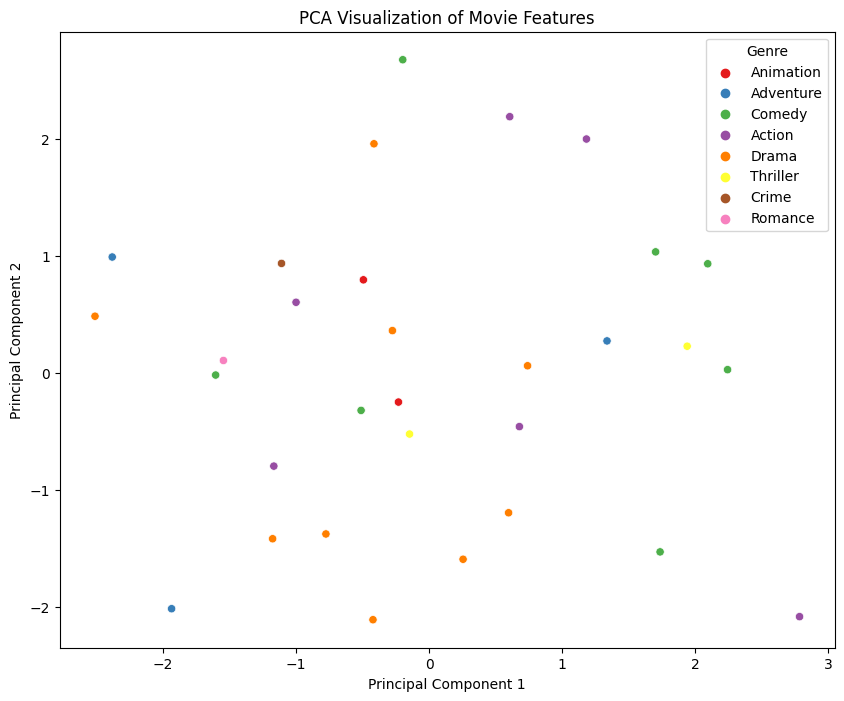

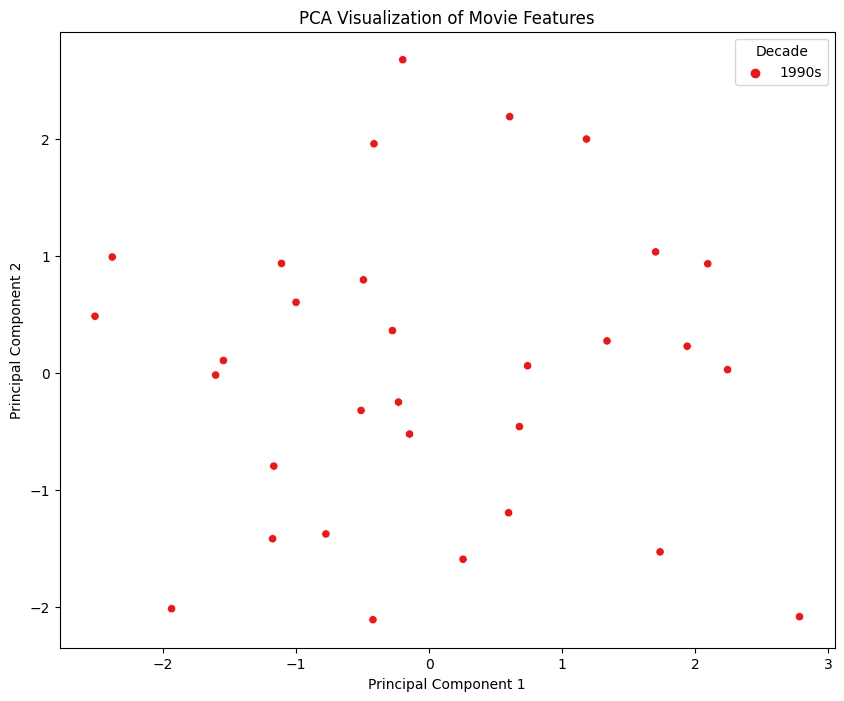

In [41]:
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(M)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)


pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Extracting genre information for labeling
pca_df['Genre'] = movies_df['Genres'].apply(lambda x: x.split('|')[0])  

# Plotting using Seaborn
#genre
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Genre', data=pca_df, palette='Set1')
plt.title('PCA Visualization of Movie Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Genre')
plt.show()

pca_df['Decade'] = movies_df['Decade']

# Plotting using Seaborn
# decade
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Decade', data=pca_df, palette='Set1', legend='full')
plt.title('PCA Visualization of Movie Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Decade', loc='upper right')
plt.show()







# t-SNE

## Users

C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Program Files\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Program Files\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python38\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


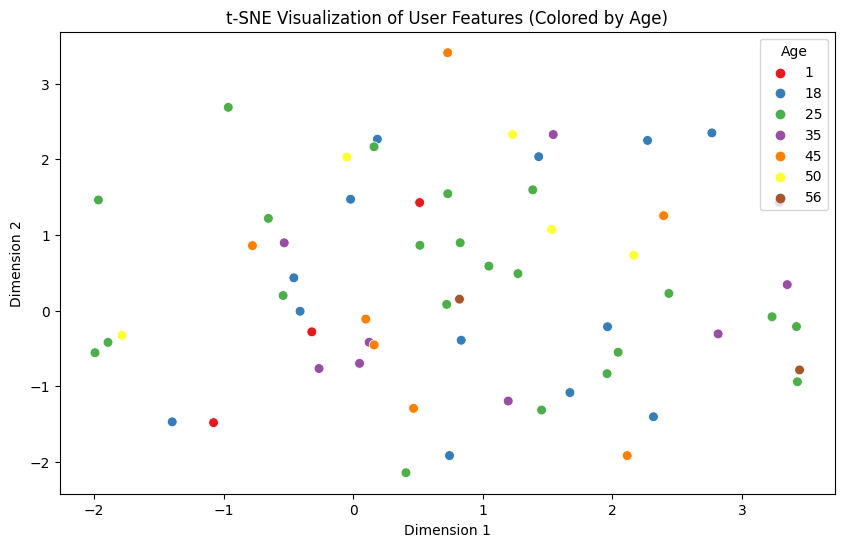

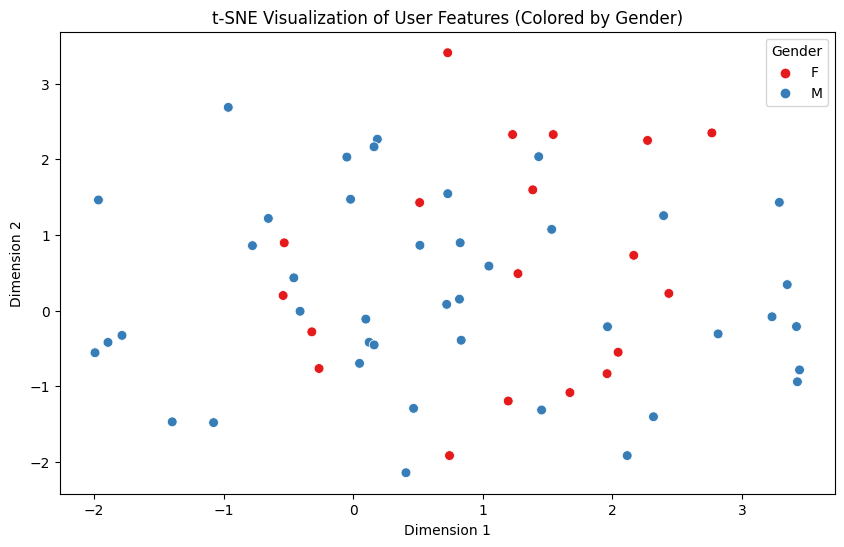

In [42]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(U)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Concatenate t-SNE results with user information
final_tsne_df = pd.concat([tsne_df, users_df[['Gender', 'Age']]], axis=1)

# Visualize using seaborn
# age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Age', data=final_tsne_df, palette='Set1', s=50)
plt.title('t-SNE Visualization of User Features (Colored by Age)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Gender', data=final_tsne_df, palette='Set1', s=50)
plt.title('t-SNE Visualization of User Features (Colored by Gender)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


## Movies

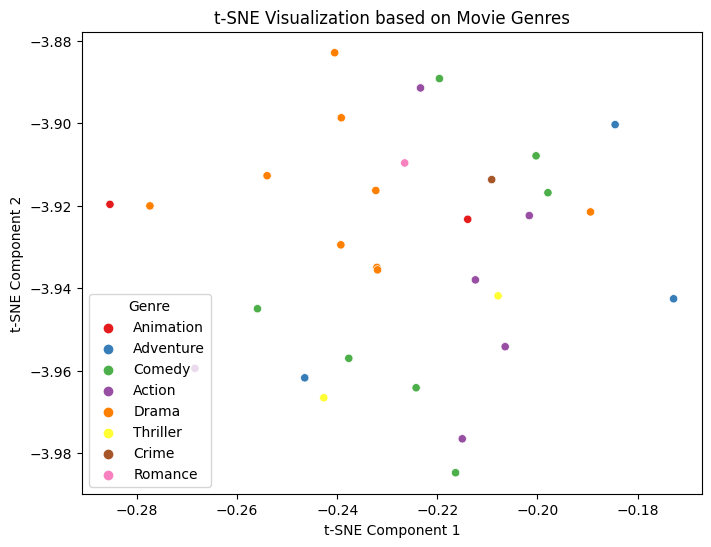

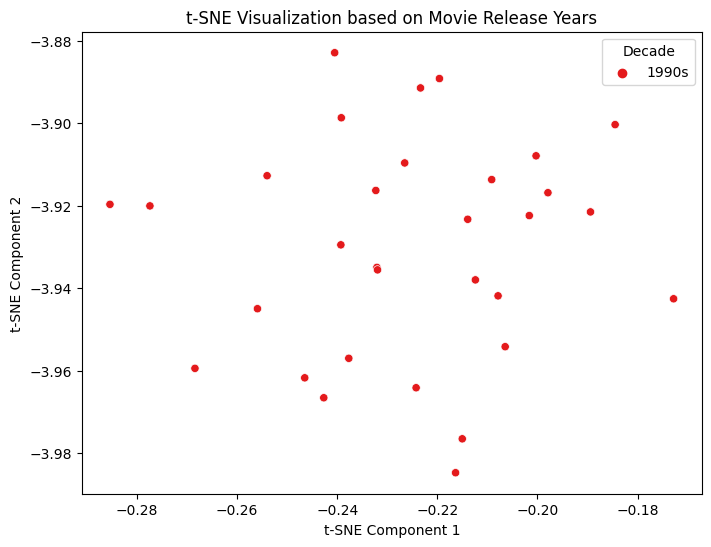

In [43]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(M)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

# Extracting genre and year information for labeling
tsne_df['Genre'] = movies_df['Genres'].apply(lambda x: x.split('|')[0])  # Extract first genre as an example
tsne_df['Decade'] = movies_df['Decade']

# Genre 
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Genre', data=tsne_df, palette='Set1')
plt.title('t-SNE Visualization based on Movie Genres')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Genre')
plt.show()

# Year 
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Decade', data=tsne_df, palette='Set1')
plt.title('t-SNE Visualization based on Movie Release Years')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Decade')
plt.show()


# UMAP

C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


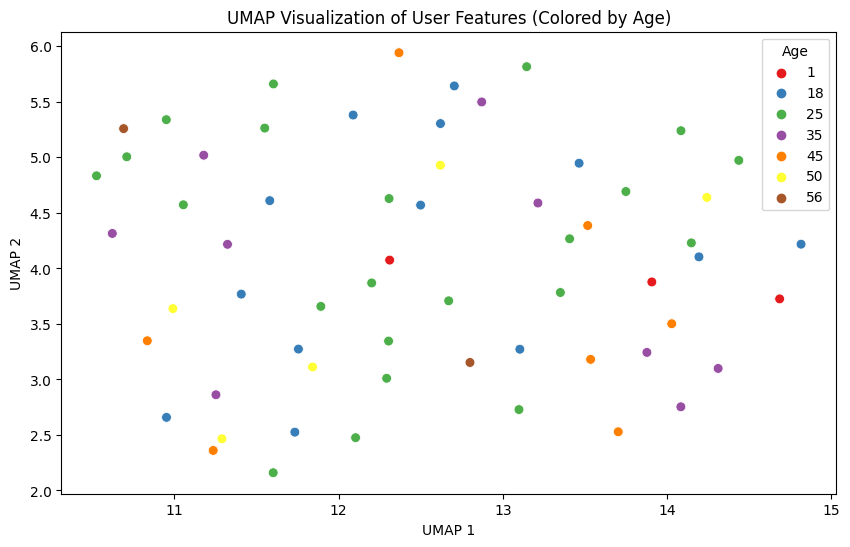

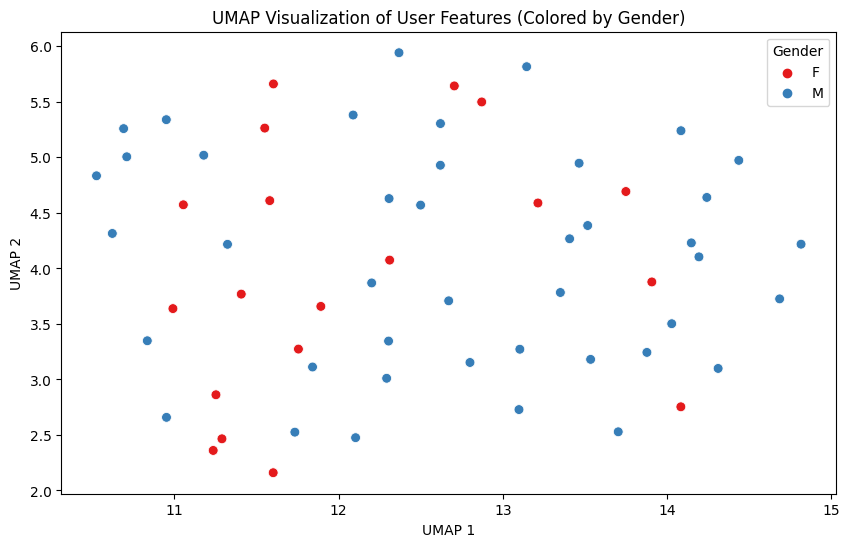

In [44]:
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(U)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP 1', 'UMAP 2'])

# Concatenate UMAP results with user information
final_umap_df = pd.concat([umap_df, users_df[['Gender', 'Age']]], axis=1)

# Visualize using seaborn
# age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Age', data=final_umap_df, palette='Set1', s=50)
plt.title('UMAP Visualization of User Features (Colored by Age)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Gender', data=final_umap_df, palette='Set1', s=50)
plt.title('UMAP Visualization of User Features (Colored by Gender)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


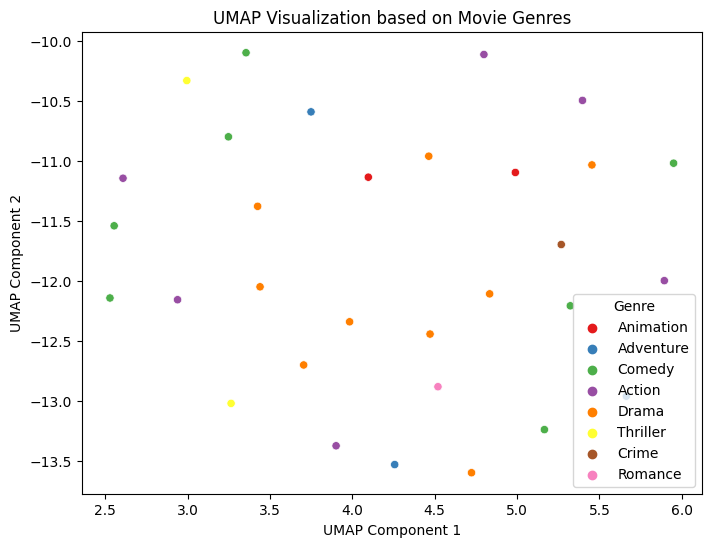

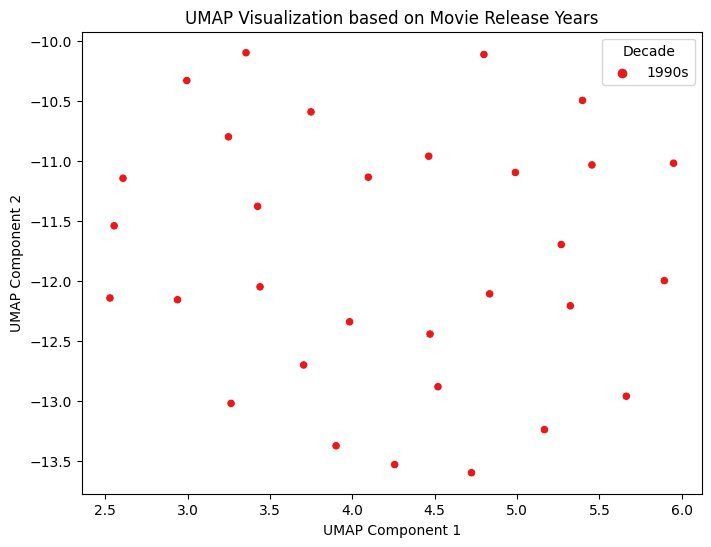

In [45]:
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(M)

# Create a DataFrame for visualization
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])

# Extracting genre and year information for labeling
umap_df['Genre'] = movies_df['Genres'].apply(lambda x: x.split('|')[0])  # Extract first genre as an example
umap_df['Decade'] = movies_df['Decade']

# Plotting based on Genre using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Genre', data=umap_df, palette='Set1')
plt.title('UMAP Visualization based on Movie Genres')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Genre')
plt.show()

# Plotting based on Year using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Decade', data=umap_df, palette='Set1')
plt.title('UMAP Visualization based on Movie Release Years')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Decade')
plt.show()
